Topic:        Challenge Set 7

Subject:      Classification Analysis on Congressional Voting Data

Date:         08/20/2017

Name:         Brendan Fitzpatrick

Worked with:  N/A

In [113]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

**Topic:  Classification**

**Settings:  Where applicable, use test_size=.30, random_state=4444.  This will permit comparison of results across users.

**Data:**

Challenges 1-10:  congressional votes [Congressional Voting Records Dataset](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)

Challenge 11:     movie data

Challenge 12:     breast cancer surgery [Haberman Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)


**Data – Congressional Votes**

Download the congressional votes data from here:[Congressional Voting Records Dataset](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)

These are votes of U.S. House of Representatives Congressmen on 16 key issues in 1984.

Read the description of the fields and download the data: house-votes-84.data

We will try to see if we can predict the house members' party based on their votes.

We will also use some of the general machine learning tools we learned (a bit more efficiently this time).

**Challenge 1**

Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [54]:
cols = np.asarray(['Party',
        'handicapped-infants',
        'water-project-cost-sharing',
        'adoption-of-the-budget-resolution',
        'physician-fee-freeze',
        'el-salvador-aid',
        'religious-groups-in-schools',
        'anti-satellite-test-ban',
        'aid-to-nicaraguan-contras',
        'mx-missile',
        'immigration',
        'synfuels-corporation-cutback',
        'education-spending',
        'superfund-right-to-sue',
        'crime',
        'duty-free-exports',
        'export-administration-act-south-africa',
       ])
cols = np.char.lower(cols)
cols = np.char.replace(cols,' ','_')
cols = np.char.replace(cols,'-','_')
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',names = cols)

In [53]:
# create dummy variable function where the mode is used for interpolation
def dummyVotes(x, mode):
    if(x == '?'):
        x = mode
        
    if(x == 'y'):
        return 1
    elif(x == 'n'):
        return 0
    else:
        return x

In [55]:
for column in df.columns[1:]:
    mode = df[column].mode().iloc[0]
    df[column] = df[column].apply(lambda x: dummyVotes(x, mode))

**Challenge 2**

Split the data into a test and training set. Use this function:

```
from sklearn.cross_validation import train_test_split
```

In [59]:
X = (df.iloc[:,1:])
y = df.iloc[:,0].to_frame()
X_test, X_train, y_test, y_train = train_test_split(X,y,test_size=0.3)

**Challenge 3**

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

```
from sklearn.neighbors import KNeighborsClassifier
```

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

```
from sklearn.metrics import accuracy_score
```

Which k value gives the highest accuracy?

In [91]:
y_train.iloc[:,0]

433    republican
249      democrat
424      democrat
343    republican
189      democrat
157      democrat
152      democrat
11     republican
132    republican
125    republican
257    republican
264      democrat
          ...    
368      democrat
408      democrat
134    republican
29       democrat
278    republican
102      democrat
243      democrat
313    republican
59     republican
205      democrat
26       democrat
126    republican
Name: party, Length: 131, dtype: object

In [93]:
# compute k-nearest neighbor accuracies for k = 1 through 20
k = [x for x in range(1, 21)]
accuracies = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train.iloc[:,0])
    y_pred = knn.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))

In [106]:
accuracies_df = pd.DataFrame(data={'k': k, 'accuracies': accuracies})

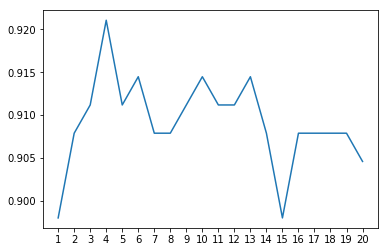

In [110]:
plt.plot(accuracies_df['k'], accuracies_df['accuracies'])
plt.xticks(k)
plt.show()

We can see from the above that KNN with k=4 is our best model with an accuracy score of 0.921

In [111]:
accuracies_df[accuracies_df.k==4].accuracies

3    0.921
Name: accuracies, dtype: float64

**Challenge 4**

Make a similar model but with `LogisticRegression` instead, calculate test accuracy.

In [102]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.iloc[:,0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
accuracy_train = logreg.score(X_train,y_train)
accuracy_test = logreg.score(X_test,y_test)
print("train_score=%.3f\ntest_score=%.3f\n" % (accuracy_train, accuracy_test))

train_score=0.939
test_score=0.944



We can see the test score for the logistic regression has a higher score then the training score. A good sign that our model is working.

Additionally, our logistic regression model's accuracy score on the test set is higher then the k-nearest neighbors accuracy score, potentially indicating a better model.

**Challenge 5**

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

/home/bf2931/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


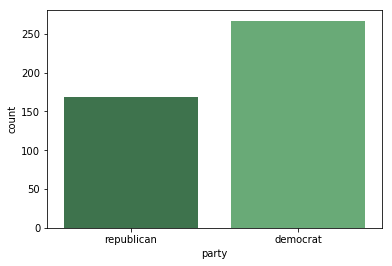

In [116]:
sns.countplot(x="party",data=df,palette="Greens_d")

In [15]:
def democrat_predictor(X):
    list = ['democrat' for _ in range(len(X))]

In [16]:
print(democrat_predictor(df.iloc[:,1:]))

0.543103448276


In [17]:
def republican_predictor(array):
    list = ['republican' for _ in range(len(X))]
    return logreg.score(array,pd.DataFrame(list))

In [18]:
print(republican_predictor(df.iloc[:,1:]))

0.456896551724


**Challenge 6**

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

In [19]:
def plot_accuracies(k,dependent,independent):
    y_vals = calculate_accuracy(k,dependent,independent)
    x_vals = []
    for x in range(1,k+1):
        x_vals.append(x)
    fig,ax = plt.subplots(1,1)
    ax.plot(x_vals,y_vals,label='ground truth',color='green')
    ax.set_ylabel('Logistic Regression Accuracy')
    ax.set_xlabel('k')

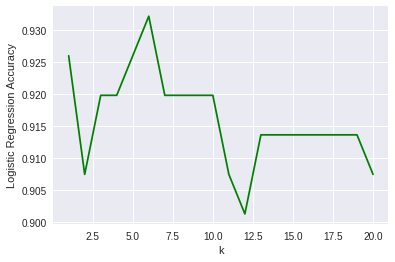

In [20]:
plot_accuracies(20,X,y.values.ravel())

**Challenge 7**

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

```
from sklearn.learning_curve import learning_curve
```

This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : )
Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:

```
train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(ts_err, axis=1)
```

Before plotting `m` vs `train_cv_err` and `m` vs `test_cv_err`, where `train_err` and `test_err` are the vectors returned by the learning curve function. The `np.mean(...., axis=1)` means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.

In [21]:
title = "Learning Curves (Logistic Regression)"
estimator = LogisticRegression()
[train_sizes, train_error, test_error]= learning_curve(estimator,df.drop('class_name',1), df.class_name)

In [22]:
train_cv_err = np.mean(train_error,axis=1)
test_cv_err = np.mean(test_error,axis=1)

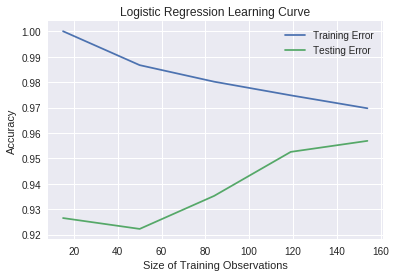

In [23]:
plt.plot(train_sizes,train_cv_err,label='Training Error')
plt.plot(train_sizes,test_cv_err,label='Testing Error')
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Size of Training Observations')
plt.ylabel('Accuracy')
plt.legend()

**Challenge 8**

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

```
from sklearn.naive_bayes import GaussianNB
```

SVM (Support Vector Machine) Classifier

```
from sklearn.svm import SVC
```

Decision Tree

```
from sklearn.tree import DecisionTreeClassifier
```

Random Forest

```
from sklearn.ensemble import RandomForestClassifier
```

In [24]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_predict = gnb.predict(X_test)
accuracy_score(y_test,gnb_predict)

0.95061728395061729

In [25]:
svc = SVC()
svc.fit(X_train,y_train)
svc_predict = svc.predict(X_test)
accuracy_score(y_test,svc_predict)

0.95679012345679015

In [26]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc_predict = dtc.predict(X_test)
accuracy_score(y_test,dtc_predict)

0.94444444444444442

In [27]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
accuracy_score(y_test,rfc_predict)

0.95679012345679015

**Challenge 9**

There is actually a way to do cross validation quickly to get your accuracy results for an algorithm, without separating training and test yourself:

```
from sklearn.cross_validation import cross_val_score
```

Just like the `learning_curve` function, this takes a classifier object, `X` and `Y`. Returns accuracy (or whatever score you prefer by using the _scoring_ keyword argument). Of course, it will return a score for each cross validation fold, so to get the generalized accuracy, you need to take the mean of what it returns.

Use this function to calculate the cross validation score of each of the classifiers you tried before.

In [28]:
np.mean(cross_val_score(gnb,df.drop('class_name',1),df.class_name))

0.93967143967143973

In [29]:
np.mean(cross_val_score(svc,df.drop('class_name',1),df.class_name))

0.96547896547896539

In [30]:
np.mean(cross_val_score(dtc,df.drop('class_name',1),df.class_name))

0.95687645687645695

In [31]:
np.mean(cross_val_score(rfc,df.drop('class_name',1), df.class_name))

0.96553446553446554

**Challenge 10**

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

Reload the data from scratch. Convert y-->1, n-->0.

Choose one vote. Build a classifier (logistic regression or KNN), that uses the other votes (do not use the party as a feature) to predict if the vote will be 1 or 0.

Convert each ? to the mode of the column (if a senator has not voted, make their vote 1 if most others voted 1, make it 0 if most others voted 0).

Calculate the cross validation accuracy of your classifier for predicting how each representative will vote on the issue.

In [32]:
df_removedNAN = df
for i in df.columns:
    df_removedNAN[i].fillna(df[i].mode(),inplace=True)

Check if all '?' have been removed:

In [33]:
unique_vals = set()
for i in cols:
    for j in df_removedNAN[i].unique():
        unique_vals.add(j)
print(unique_vals)

{'republican', 'democrat', 0.0, 1.0}


In [34]:
logreg = LogisticRegression()
np.mean(cross_val_score(logreg,df_removedNAN.drop(['education_spending','class_name'],1),df_removedNAN.education_spending))

0.90071040071040065

**Challenge 11**

Back to movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

Make a bar graph of how many of each movie there is in the data. For example, with Ratings, show how many G, PG, PG-13, R movies there are, etc. (basically a histogram of your labels).

Predict your outcome variable (labels) using KNN and logistic regression. Calculate their accuracies.

Make a baseline stupid predictor that always predicts the label that is present the most in the data. Calculate its accuracy on a test set.

How much better do KNN and logistic regression do versus the baseline?

What are the coefficients of logistic regression? Which features affect the outcome how?

In [35]:
df_movies = pd.read_csv('2013_movies.csv')

In [36]:
df_movies.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,1.300e+08,424668047,Francis Lawrence,PG-13,146,2013-11-22 00:00:00
1,Iron Man 3,2.000e+08,409013994,Shane Black,PG-13,129,2013-05-03 00:00:00
2,Frozen,1.500e+08,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22 00:00:00
3,Despicable Me 2,7.600e+07,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03 00:00:00
4,Man of Steel,2.250e+08,291045518,Zack Snyder,PG-13,143,2013-06-14 00:00:00


In [37]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
Title                 100 non-null object
Budget                89 non-null float64
DomesticTotalGross    100 non-null int64
Director              96 non-null object
Rating                100 non-null object
Runtime               100 non-null int64
ReleaseDate           100 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.5+ KB


In [38]:
df_movies.dropna(axis=0,inplace=True)
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 99
Data columns (total 7 columns):
Title                 87 non-null object
Budget                87 non-null float64
DomesticTotalGross    87 non-null int64
Director              87 non-null object
Rating                87 non-null object
Runtime               87 non-null int64
ReleaseDate           87 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.4+ KB


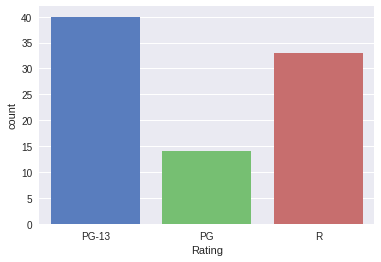

In [39]:
df_movies.Rating = df_movies.Rating.str.strip()
df_movies['Rating_cat'] = df_movies.Rating.astype("category", categories=["G","PG","PG-13","R"], ordered=True)
sns.countplot(x='Rating',data=df_movies,palette='muted')

In [40]:
X_mov_train, X_mov_test, y_mov_train, y_mov_test = train_test_split(df_movies[['Budget','DomesticTotalGross','Runtime']],df_movies.Rating.values.ravel(),test_size=0.3)

In [41]:
logreg = LogisticRegression()
logreg.fit(X_mov_train,y_mov_train)
predict = logreg.predict(X_mov_test)
accuracy_score(y_mov_test,predict)

0.59259259259259256

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_mov_train,y_mov_train)
predict = knn.predict(X_mov_test)
accuracy_score(y_mov_test,predict)

0.59259259259259256

In [44]:
def pg13_predictor(X):
    list = ['PG-13' for _ in range(len(X))]
    return(accuracy_score(y_mov_test,np.array(list)))

In [45]:
pg13_predictor(X_mov_test)

0.51851851851851849

**Challenge 12**

Now you are a classification master. The representative votes dataset only had 0s and 1s. Let's just swiftly tackle the breast cancer surgery data.

Get it from here: [Haberman Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)

 * What is the average and standard deviation of the age of all of the patients?
 * What is the average and standard deviation of the age of those patients that survived 5 or more years after surgery?
 * What is the average and standard deviation of the age of those patients who survived fewer than 5 years after surgery?
 * Plot a histogram of the ages side by side with a histogram of the number of axillary nodes.
 * What is the earliest year of surgery in this dataset?
 * What is the most recent year of surgery?
 * Use logistic regression to predict survival after 5 years. How well does your model do?
 * What are the coefficients of logistic regression? Which features affect the outcome how?
 * Draw the learning curve for logistic regression in this case.